# Signature-Based Two Sample Hypothesis Testing

## Scaled Brownian Motion - Asymptotic Fit and Probability of a Type 2 Error Occurring

### Andrew Alden

### Table of Contents

- [Initial Setup](#initial-setup)
- [Two-Sample Hypothesis Testing](#hyp-test)
- [Asymptotic Fit](#asymp-fit)
    - [Gamma Fit Under Null Hypothesis](#asymp-fit-gamma)
    - [Asymptotic Fit Under Null and Alternative Hypotheses](#asymp-fit-both)
    - [Asymptotic Fit Under Alternative Hypothesis](#asymp-fit-alt)
- [Analysis of the Probability of a Type 2 Error Occurring](#prob-type2)
    - [Unbiased Estimator](#prob-type2-ub)
    - [Biased Estimator](#prob-type2-b)
    - [Surface Plots Using Closed-Form Formulae](#prob-type2-surface)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

### Import libraries 

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
from collections import defaultdict
from scipy import stats
from scipy.stats import norm
from scipy.special import gamma
from pathlib import Path

from src.utils.plotting_functions import plot_dist


from src.mmd.distribution_functions import return_mmd_distributions, get_level_values
from src.mmd.mmd import SigKernel, LinearKernel
from src.mmd.scaled_bm_stats import *
from src.mmd.two_sample_stats import *

from src.StochasticProcesses.ScaledBM import generate_scaled_brownian_motion_paths


In [3]:
import sys
import types

numpy_core_fake = types.ModuleType("numpy._core")
sys.modules["numpy._core"] = numpy_core_fake

numpy_core_fake.multiarray = np.core.multiarray
numpy_core_fake.numeric = np.core.numeric
numpy_core_fake.umath = np.core.umath

sys.modules["numpy._core.multiarray"] = np.core.multiarray
sys.modules["numpy._core.numeric"] = np.core.numeric
sys.modules["numpy._core.umath"] = np.core.umath

### Set device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Signature Kernel

In [4]:
dyadic_order  = 0
static_kernel = LinearKernel()

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

## Two-Sample Hypothesis Testing <a class="anchor" id="hyp-test"></a>

In [75]:
T = 1
grid_points = 32
path_bank_size = 32768

sig, beta = 0.25, 0.35
h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

n_atoms   = 500
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists, _ = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub',
    u_stat=False
)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.52it/s]


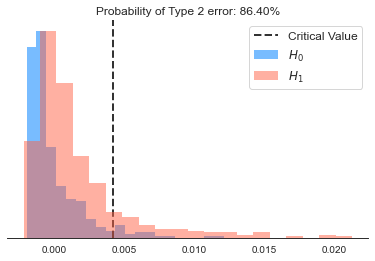

In [76]:
plot_dist(h0_dists, h1_dists, n_atoms, alpha)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.44it/s]


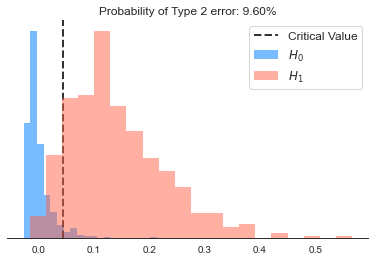

In [77]:
scaling = 3.0
h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths[:, :, :]), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths[:, :, :]), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub',
    u_stat=False
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha)

## Asymptotic Fit <a class="anchor" id="asymp-fit"></a>

### Gamma Fit Under Null Hypothesis <a class="anchor" id="asymp-fit-gamma"></a>

100%|██████████| 5000/5000 [05:07<00:00, 16.28it/s]


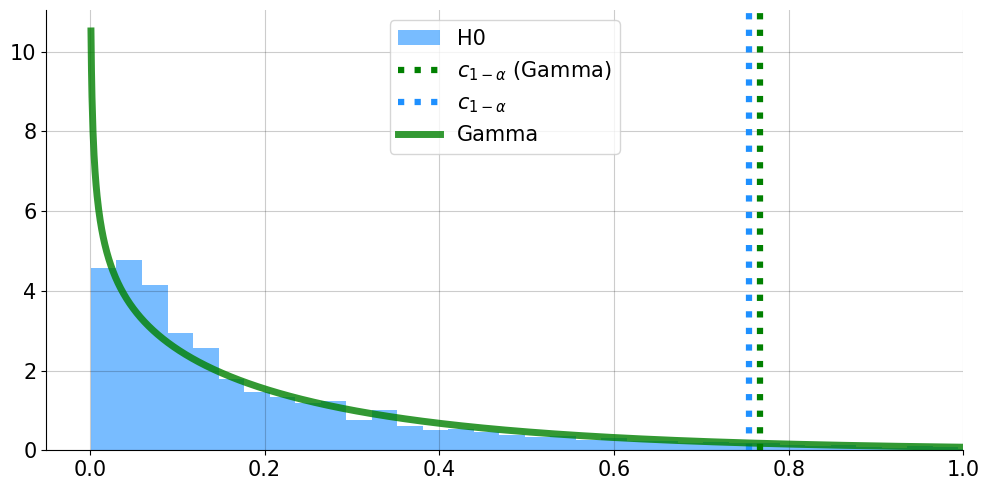

In [6]:
sig, beta = 0.25, 0.35

path_bank_size = 100000
grid_points = 49

T = 1.0

h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

n_atoms   = 5000
n_paths   = 128
alpha = 0.05

h0_dists, h1_dists, _ = return_mmd_distributions(
    h0_paths, 
    h1_paths, 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='b',
    u_stat=False
)


fig, ax = plt.subplots(figsize=(10, 5))

epsilon = 0.0
alpha = 0.05

scale = lambda mean, var, N: mean**2/var
rate  = lambda mean, var, N: (N*var)/mean

mean = Exp_MMD_2_b(sig, sig, n_paths)
var  = Var_MMD_2_b(sig, sig, n_paths)

mu    = scale(mean, var, n_paths)
theta = rate(mean, var, n_paths)

_pdf = lambda x: pdf(x, mu, theta, n_paths)
_cdf = lambda x: cdf(x, mu, theta, n_paths)

rng      = torch.linspace(n_paths*torch.Tensor(h0_dists).min(), n_paths*torch.Tensor(h0_dists).max(), len(h0_dists))
pdf_vals = torch.tensor([_pdf(xi) for xi in rng])

ax.hist(n_paths*np.asarray(h0_dists), bins=100, color='dodgerblue', alpha=0.6, density=True, edgecolor='none', label='H0')
ax.axvline(ppf(1-alpha, mu, theta, n_paths), color='green', alpha=1.0, linewidth=4.5, linestyle=':', label=r'$c_{1-\alpha}$ (Gamma)')
ax.axvline(n_paths*np.sort(np.asarray(h0_dists))[int(len(h0_dists) * (1 - alpha))], color='dodgerblue', alpha=1.0, linewidth=4.5, linestyle=':', label=r'$c_{1-\alpha}$')
ax.plot(rng, pdf_vals, color="green", alpha=0.8, label='Gamma', linewidth=5.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True, color='black', alpha=0.2)
ax.legend(loc='best', fontsize=15)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.set_xlim([-0.05, 1])
plt.tight_layout()
filename = 'ScaledBMImages/scaledbm_gammafit_025_035.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

### Asymptotic Fit Under Null and Alternative Hypotheses <a class="anchor" id="asymp-fit-both"></a>

100%|██████████| 500/500 [00:13<00:00, 38.16it/s]


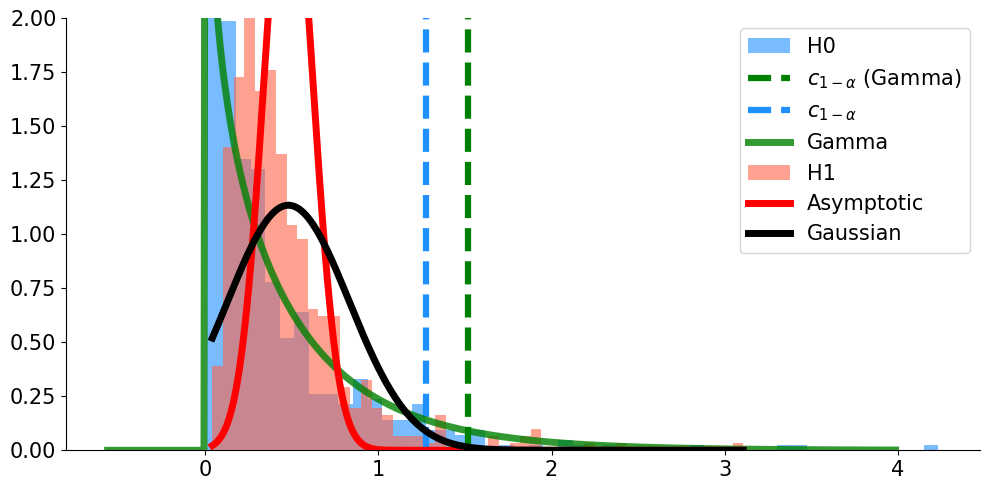

100%|██████████| 500/500 [00:13<00:00, 38.16it/s]


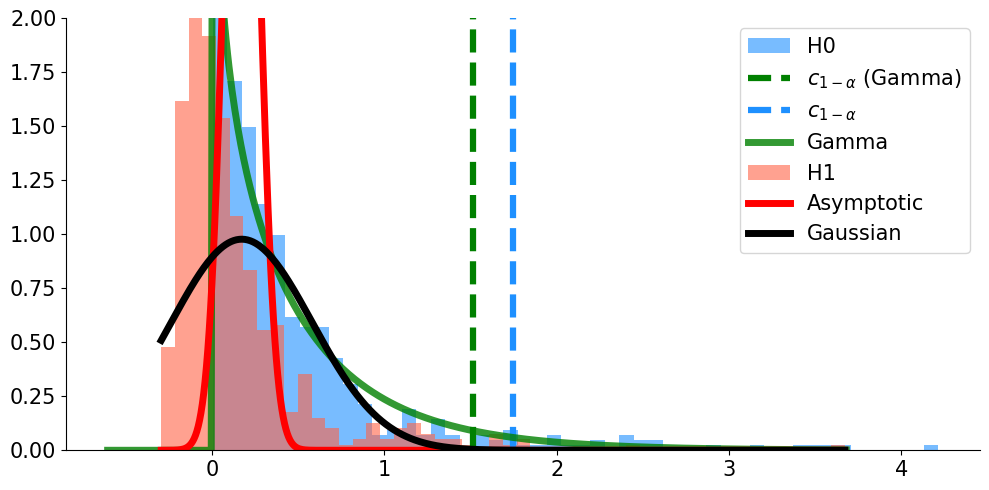

100%|██████████| 500/500 [00:13<00:00, 38.16it/s]


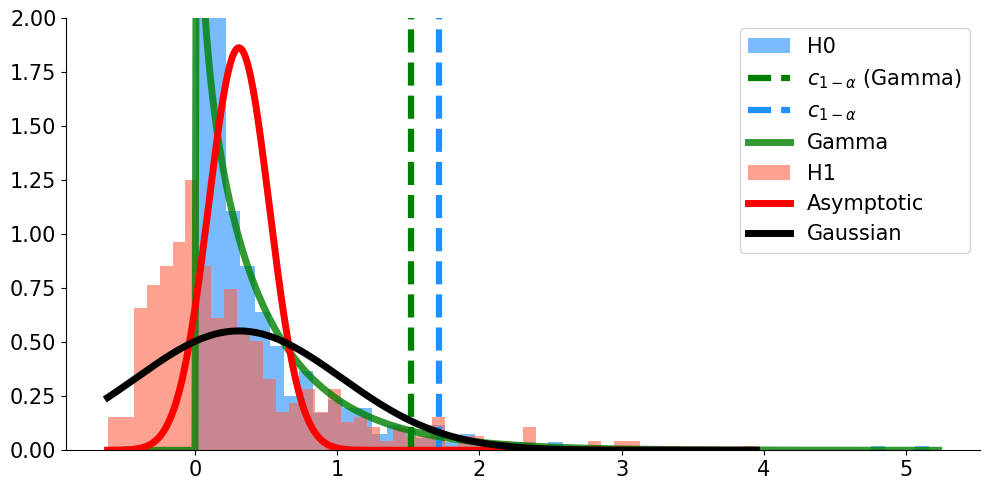

100%|██████████| 500/500 [00:13<00:00, 38.16it/s]


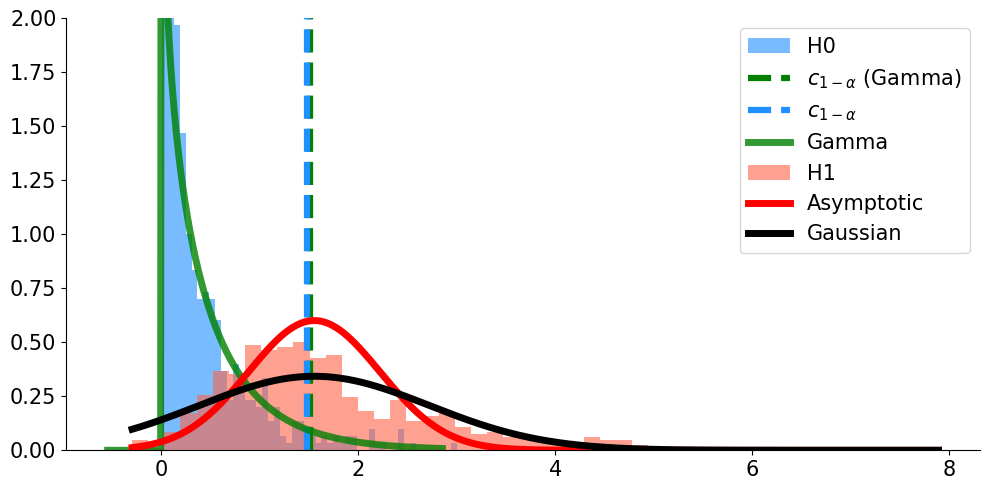

100%|██████████| 500/500 [00:13<00:00, 38.16it/s]


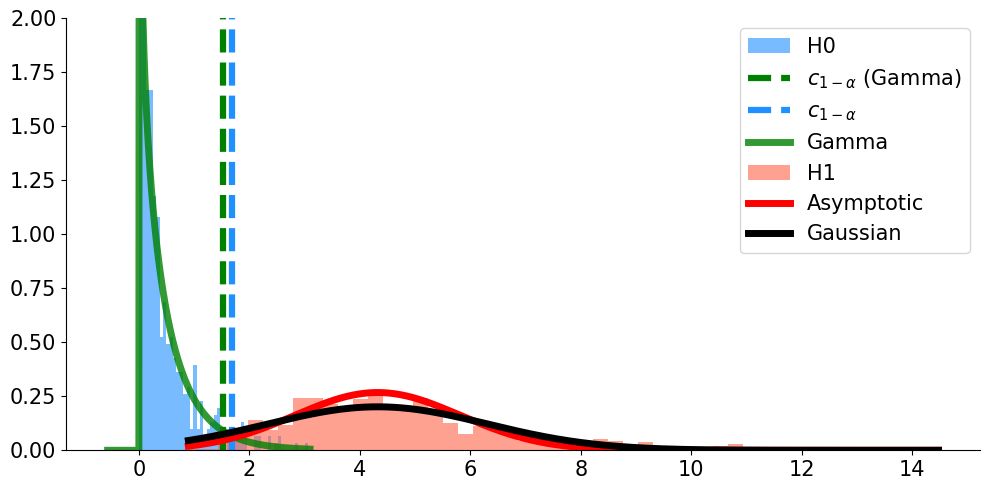

100%|██████████| 500/500 [00:13<00:00, 38.15it/s]


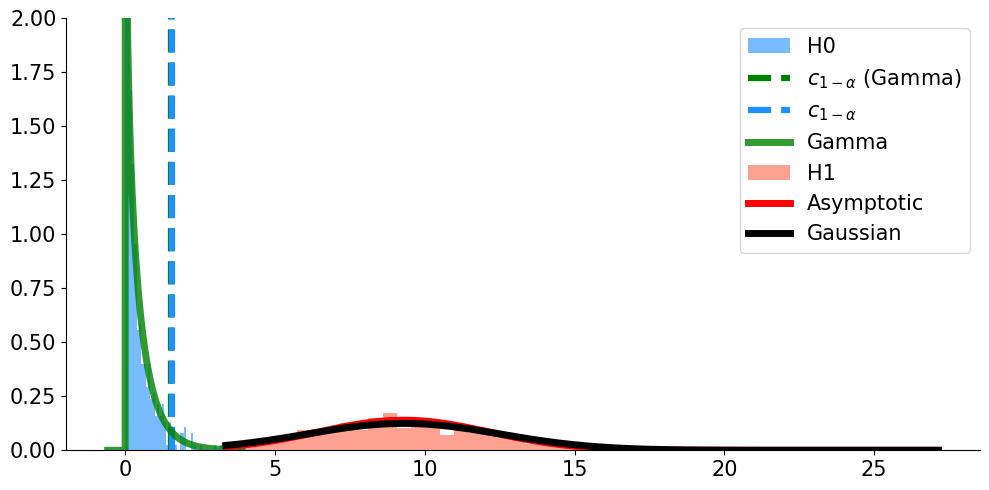

100%|██████████| 500/500 [00:13<00:00, 38.16it/s]


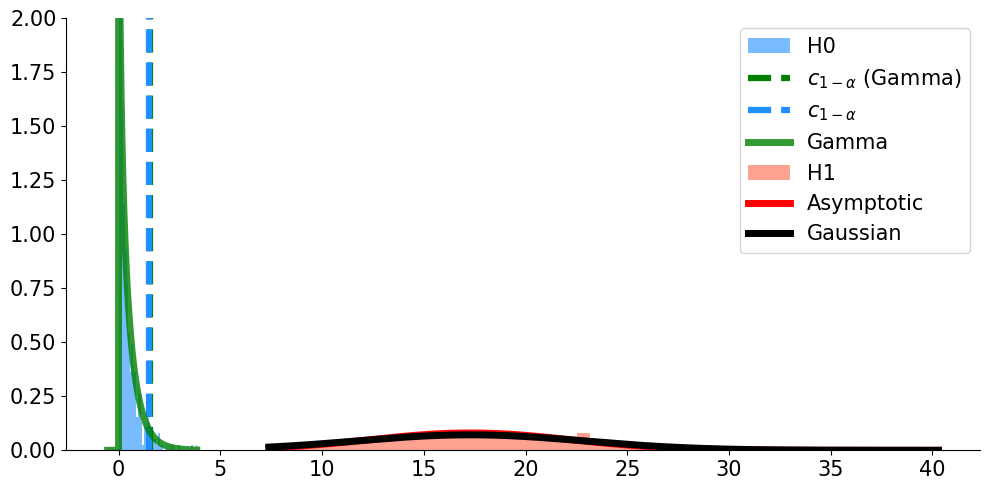

In [8]:
scale = lambda mean, var, N: mean**2/var
rate  = lambda mean, var, N: (N*var)/mean

_pdf = lambda x: pdf(x, mu, theta, n_paths)


sig = 0.35

n_atoms = 500
n_paths = 128
alpha = 0.05
path_bank_size = 10000
grid_points = 32

T = 1.0

for i in range(0, 8):
            
    beta = 0.25 + 0.1 * (i-1)
    
    if beta != sig:
        
        fig, ax = plt.subplots(figsize=(10, 5))

    
        h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
        h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

        h0_dists, h1_dists, _ = return_mmd_distributions(
            h0_paths, 
            h1_paths, 
            signature_kernel.compute_mmd, 
            n_atoms=n_atoms, 
            batch_size=n_paths, 
            estimator='ub',
            u_stat=True
        )

        h0_dists_b, h1_dists_b, _ = return_mmd_distributions(
            h0_paths, 
            h1_paths, 
            signature_kernel.compute_mmd, 
            n_atoms=n_atoms, 
            batch_size=n_paths, 
            estimator='b',
            u_stat=False
        )

        mean_h1 = Exp_Gamma_2_ub(sig, beta, T) + Exp_Gamma_3_ub(sig, beta, T)
        var_h1_true = np.var(h1_dists)
        var_h1 = trunc_vol_H_A_dist(sig, beta, T)


        scale_h1 = np.sqrt(var_h1 * n_paths)
        loc_h1 = mean_h1 * n_paths

        _gaussian_pdf = lambda x: gaussian_pdf(x, loc_h1, scale_h1)
        _gaussian_pdf_true = lambda x: gaussian_pdf(x, loc_h1, np.sqrt(var_h1_true) * n_paths)

        rng_h1      = torch.linspace(n_paths*torch.Tensor(h1_dists).min(), n_paths*torch.Tensor(h1_dists).max(), len(h1_dists))
        gaussian_pdf_vals = torch.tensor([_gaussian_pdf(xi) for xi in rng_h1])
        gaussian_pdf_vals_true = torch.tensor([_gaussian_pdf_true(xi) for xi in rng_h1])

        mean = Exp_MMD_2_b(sig, sig, n_paths)
        var  = Var_MMD_2_b(sig, sig, n_paths)

        mu    = scale(mean, var, n_paths)
        theta = rate(mean, var, n_paths)

        rng      = torch.linspace(n_paths*torch.Tensor(h0_dists).min(), n_paths*torch.Tensor(h0_dists).max(), len(h0_dists))
        pdf_vals = torch.tensor([_pdf(xi) for xi in rng])


        ax.hist(n_paths*np.asarray(h0_dists_b), bins=50, color='dodgerblue', alpha=0.6, density=True, edgecolor='none', label='H0')
        ax.axvline(ppf(1-alpha, mu, theta, n_paths), color='green', alpha=1.0, linewidth=4.5, linestyle='--', label=r'$c_{1-\alpha}$ (Gamma)')
        ax.axvline(n_paths*np.sort(np.asarray(h0_dists_b))[int(len(h0_dists_b) * (1 - alpha))], color='dodgerblue', alpha=1.0, linewidth=4.5, linestyle='--', label=r'$c_{1-\alpha}$')
        ax.plot(rng, pdf_vals, color="green", alpha=0.8, label='Gamma', linewidth=5)

        ax.hist((n_paths) * np.asarray(h1_dists), bins=50, color='tomato', alpha=0.6, density=True, edgecolor='none', label='H1')
        ax.plot(rng_h1, gaussian_pdf_vals, color="red", alpha=1.0, label='Asymptotic', linewidth=5)
        ax.plot(rng_h1, gaussian_pdf_vals_true, color="black", alpha=1.0, label='Gaussian', linewidth=5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend(loc='best', fontsize=15)
        plt.setp(ax.get_xticklabels(), fontsize=15)
        plt.setp(ax.get_yticklabels(), fontsize=15)
        ax.set_ylim([0.0, 2.0])

        plt.tight_layout()
        filename = f'ScaledBMImages/scaledbm_biasedmmd_fit_{n_paths}_{beta}_v2.svg'
        file_path = Path(filename)
        file_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
        plt.show()

### Asymptotic Fit Under Alternative Hypothesis <a class="anchor" id="asymp-fit-alt"></a>

100%|██████████| 500/500 [03:16<00:00,  2.54it/s]


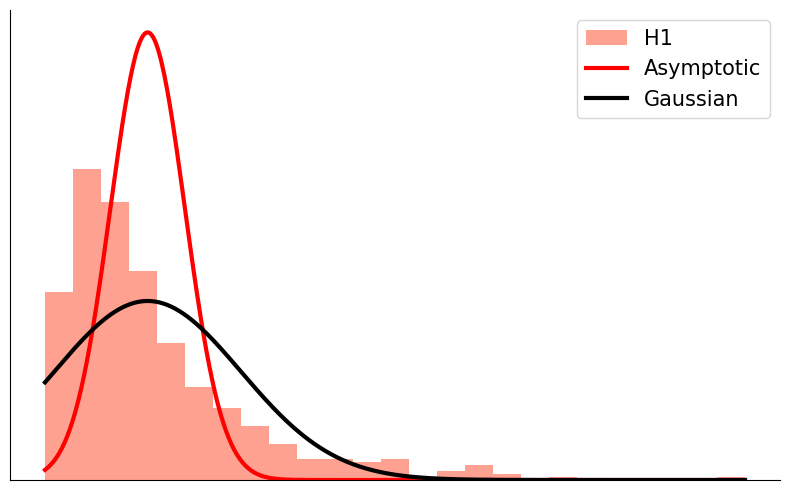

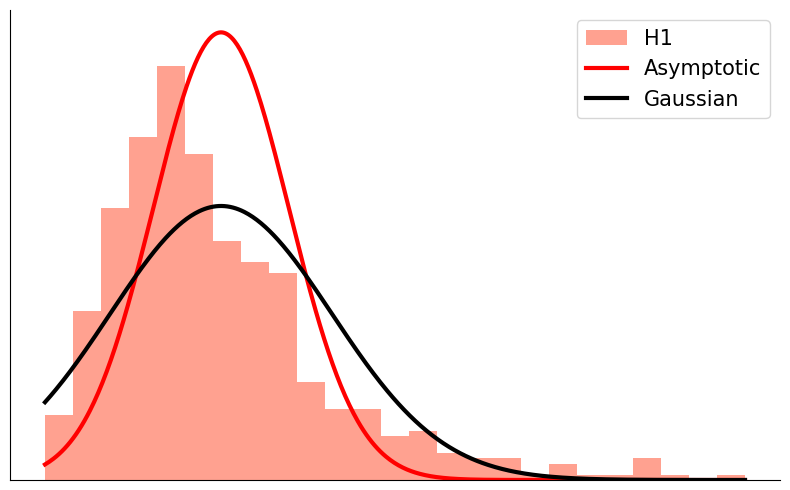

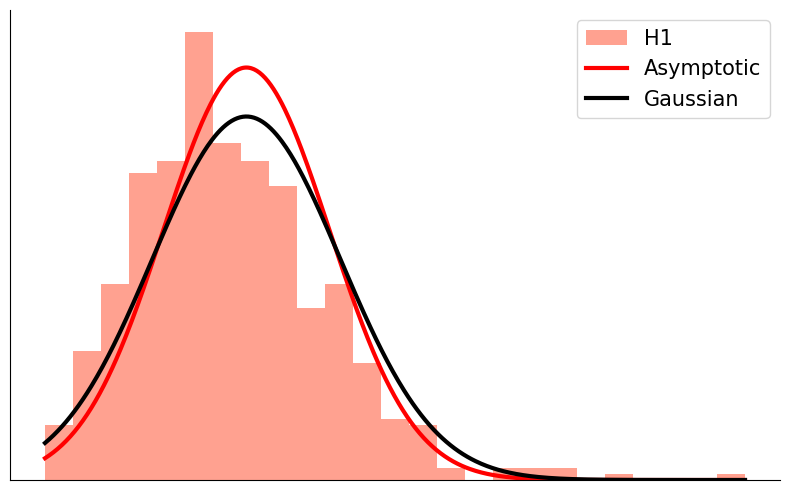

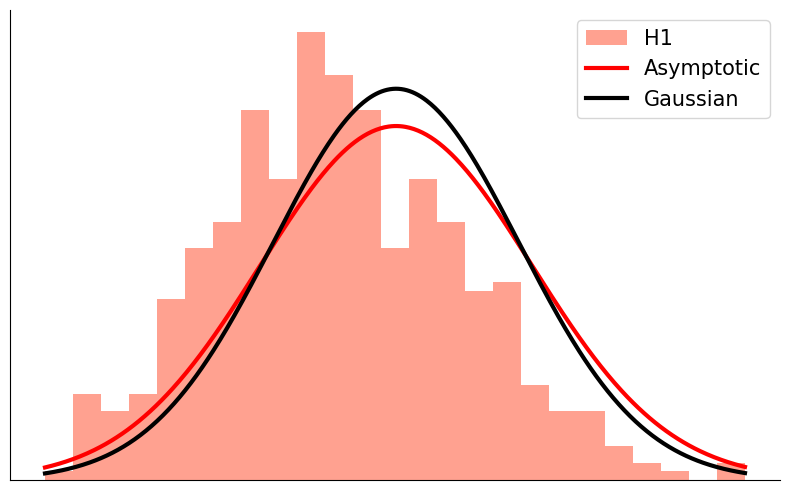

In [20]:
ks = [1, 2, 3]
n_atoms = 500
path_bank_size = 10000
grid_points = 34
sig = 0.35
beta = 0.55


for i, T in enumerate([1.0]):

    h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
    h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)
    
    for j, n_paths in enumerate([64, 128, 512, 2000]):

        fig, ax = plt.subplots(figsize=(8, 5))

        
        h0_Mk_vals, h1_Mk_vals = get_level_values(h0_paths, h1_paths, n_atoms, n_paths, ks, path_bank_size, unbiased=True, u_stat=True)
        h0_Mk_vals = np.asarray(h0_Mk_vals)
        h1_Mk_vals = np.asarray(h1_Mk_vals)
    
    
        h0_dists = np.sum(h0_Mk_vals, axis=0)
        h1_dists = np.sum(h1_Mk_vals, axis=0)
    
        mean_h1 = Exp_MMD_3_ub(sig, beta, T)
        var_h1_true = np.var(h1_dists)
        var_h1 = trunc_vol_H_A_dist(sig, beta, T)
    
    
        scale_h1 = np.sqrt(var_h1 * 1/n_paths)
        loc_h1 = mean_h1
    
        _gaussian_pdf = lambda x: gaussian_pdf(x, loc_h1, scale_h1)
        _gaussian_pdf_true = lambda x: gaussian_pdf(x, loc_h1, np.sqrt(var_h1_true))
    
        rng_h1 = torch.linspace(torch.Tensor(h1_dists).min(), torch.Tensor(h1_dists).max(), len(h1_dists))
        gaussian_pdf_vals = torch.tensor([_gaussian_pdf(xi) for xi in rng_h1])
        gaussian_pdf_vals_true = torch.tensor([_gaussian_pdf_true(xi) for xi in rng_h1])
    
        ax.hist(np.asarray(h1_dists), bins=25, color='tomato', alpha=0.6, density=True, edgecolor='none', label=f'H1')
        ax.plot(rng_h1, gaussian_pdf_vals, color="red", alpha=1.0, label='Asymptotic', linewidth=3.0)
        ax.plot(rng_h1, gaussian_pdf_vals_true, color="black", alpha=1.0, label='Gaussian', linewidth=3.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.grid(True, color='black', alpha=0.2)
        ax.legend(loc='best', fontsize=15)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])
        
        plt.tight_layout()
        filename = f'ScaledBMImages/scaledbm_biasedmmd_fit_{n_paths}_{beta}_trunclvl2.svg'
        file_path = Path(filename)
        file_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
    
    plt.show()

## Analysis of the Probability of a Type 2 Error Occurring <a class="anchor" id="prob-type2"></a>


In [7]:
param_list_dict = {'sig': [0.25, 0.5, 0.75], 
                   'beta': np.linspace(0.05, 1.0, 20)}

h0_param_key = 'sig'
iterator_keys = ['sig', 'beta']
n_atoms = 100
num_sim = 25

error_dicts_ub = {}
error_dicts_b = {}
for T in tqdm([0.5, 1.0]):
    for n_paths in tqdm([16, 32, 64, 128]):
        error_dict = type2errors_sim(param_list_dict, h0_param_key, iterator_keys, n_atoms, signature_kernel,
                                     estimator='ub', num_sim=num_sim, verbose1=False, verbose2=False, device=device, T=T, n_paths=n_paths)
        error_dicts_ub[f'{T, n_paths}'] = error_dict

        error_dict = type2errors_sim(param_list_dict, h0_param_key, iterator_keys, n_atoms, signature_kernel,
                                     estimator='b', num_sim=num_sim, verbose1=False, verbose2=False, device=device, T=T, n_paths=n_paths)
        error_dicts_b[f'{T, n_paths}'] = error_dict

100%|██████████| 2/2 [7:47:55<00:00, 14037.82s/it]  


Save simulations. 

In [8]:
filename = f'ScaledBMData/type2_dict_fit_beta_ub_FULLSIM'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)

with open(filename, 'wb') as f:
    pickle.dump(error_dicts_ub, f)

with open('ScaledBMData/type2_dict_fit_beta_b_FULLSIM', 'wb') as f:
    pickle.dump(error_dicts_b, f)

Load simulations.

In [4]:
with open('ScaledBMData/type2_dict_fit_beta_ub_FULLSIM', 'rb') as f:
    error_dicts_ub = pickle.load(f)

with open('ScaledBMData/type2_dict_fit_beta_b_FULLSIM', 'rb') as f:
    error_dicts_b = pickle.load(f)

### Unbiased Estimator <a class="anchor" id="prob-type2-ub"></a>

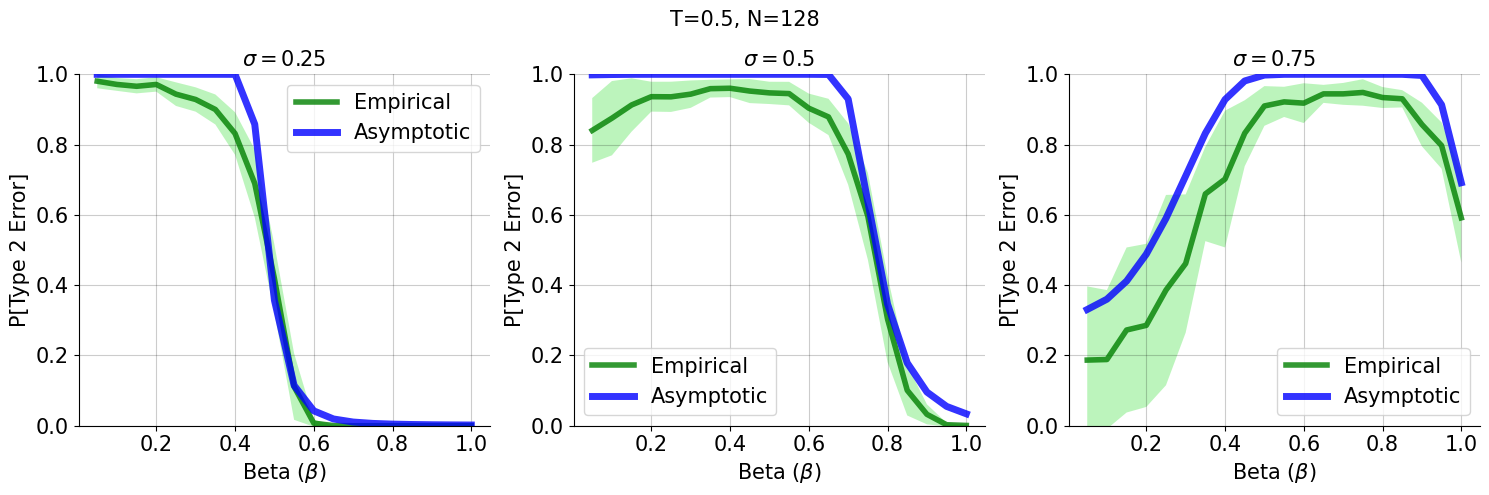

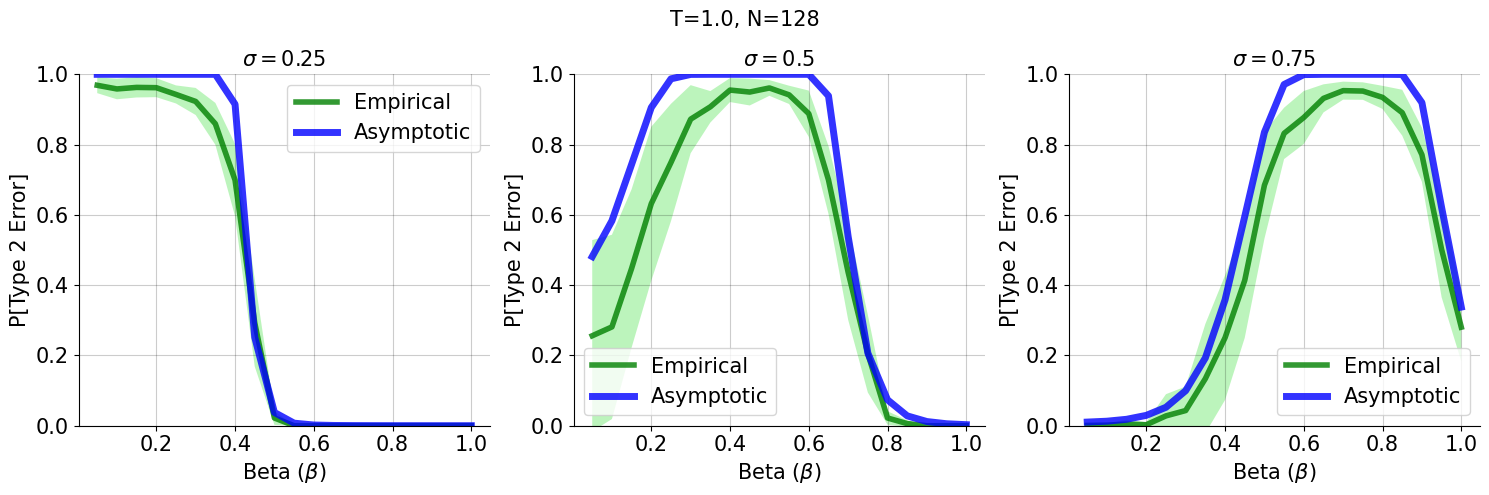

In [12]:
for T in [0.5, 1.0]:
    for n_paths in [128]:
        error_dict = error_dicts_ub[f'{T, n_paths}']
        fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
        for i, sig in enumerate([0.25, 0.5, 0.75]):
            sim_res = np.asarray(error_dict[f'{sig}'][0])
            ax[i].plot(np.linspace(0.05, 1.0, 20), sim_res[:, 0], alpha=0.8, label=f'Empirical', color='green', linewidth=4.0)
            ax[i].fill_between(np.linspace(0.05, 1.0, 20), sim_res[:, 0] - sim_res[:, 1], sim_res[:, 0] + sim_res[:, 1], color='lightgreen', alpha=0.6, edgecolor='none')
            ax[i].plot(np.linspace(0.05, 1.0, 20), error_dict[f'{sig}'][1], color='blue', linewidth=5.0, alpha=0.8, label='Asymptotic')
            ax[i].grid(True, color='black', alpha=0.2)
            ax[i].legend(loc='best', fontsize=15)
            ax[i].set_ylabel(r"P[Type 2 Error]", fontsize=15)
            ax[i].set_xlabel(r"Beta ($\beta$)", fontsize=15)
            ax[i].set_title(r'$\sigma=$' + f'{sig}', fontsize=15)
            plt.setp(ax[i].get_xticklabels(), fontsize=15)
            plt.setp(ax[i].get_yticklabels(), fontsize=15)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            ax[i].set_ylim([0, 1])
        plt.tight_layout()
        filename = f'ScaledBMImages/scaledbm_unbiasedmmd_typ2prob_fit_{n_paths}_{T}.svg'
        file_path = Path(filename)
        file_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
        plt.suptitle(f'T={T}, N={n_paths}', fontsize=15)
        plt.tight_layout()
        plt.show()

### Biased Estimator <a class="anchor" id="prob-type2-b"></a>

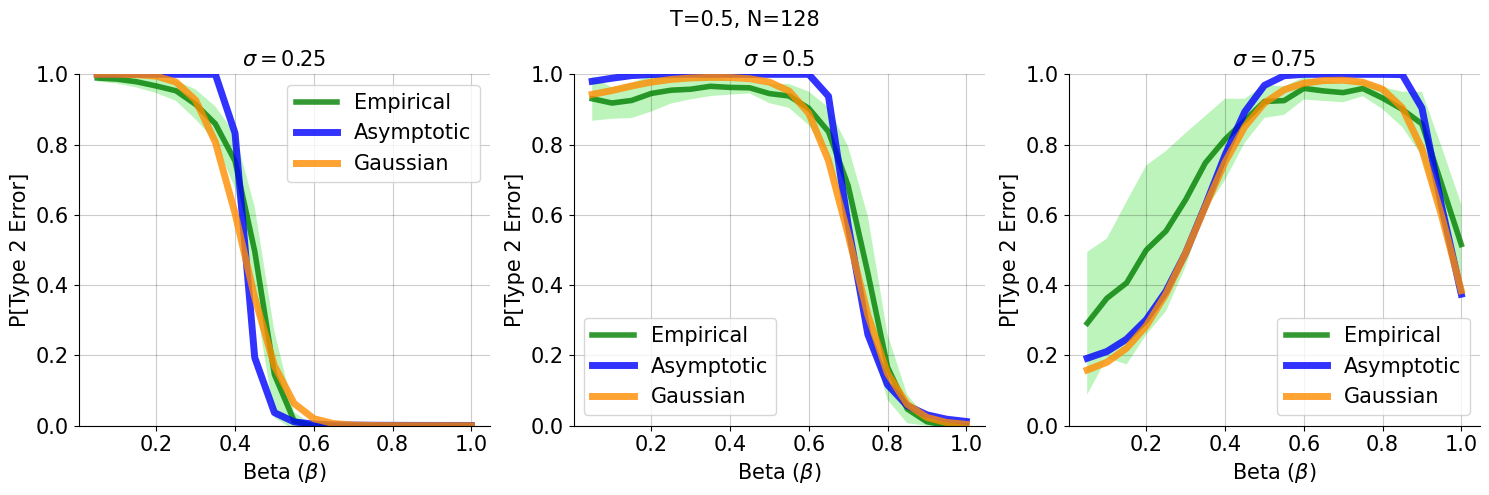

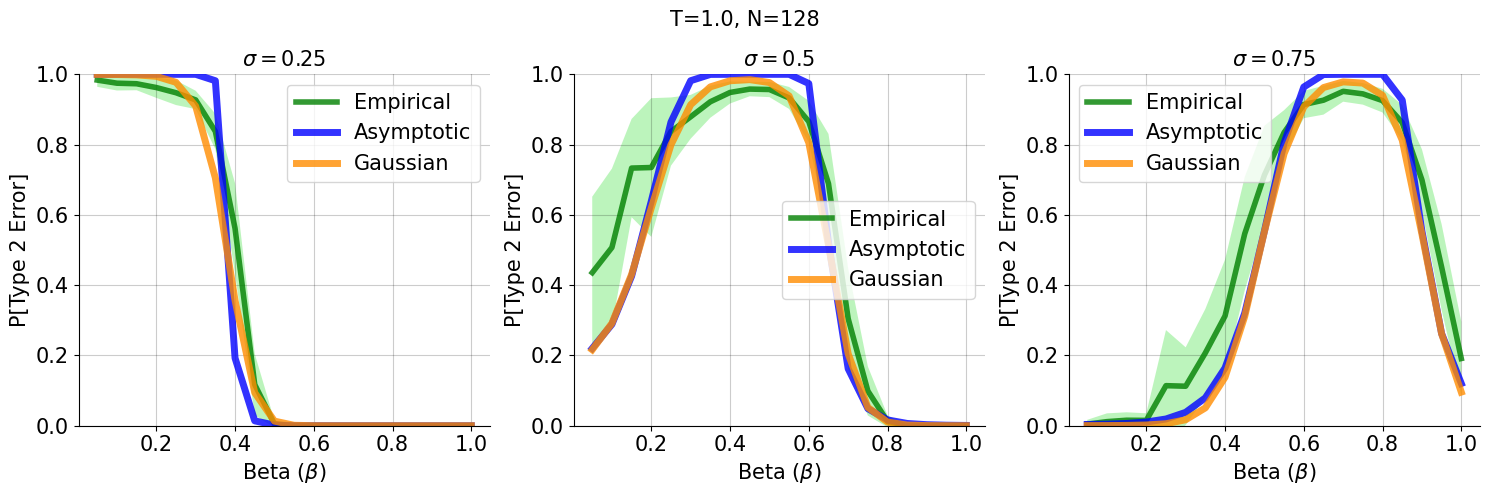

In [10]:
for T in [0.5, 1.0]:
    for n_paths in [128]:
        error_dict = error_dicts_b[f'{T, n_paths}']
        fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
        for i, sig in enumerate([0.25, 0.5, 0.75]):
            sim_res = np.asarray(error_dict[f'{sig}'][0])
            ax[i].plot(np.linspace(0.05, 1.0, 20), sim_res[:, 0], alpha=0.8, label=f'Empirical', color='green', linewidth=4.0)
            ax[i].fill_between(np.linspace(0.05, 1.0, 20), sim_res[:, 0] - sim_res[:, 1], sim_res[:, 0] + sim_res[:, 1], color='lightgreen', alpha=0.6, edgecolor='none')
            ax[i].plot(np.linspace(0.05, 1.0, 20), error_dict[f'{sig}'][1], color='blue', linewidth=5.0, alpha=0.8, label='Asymptotic')
            ax[i].plot(np.linspace(0.05, 1.0, 20), error_dict[f'{sig}'][2], color='darkorange', linewidth=5.0, alpha=0.8, label='Gaussian')
            ax[i].grid(True, color='black', alpha=0.2)
            ax[i].legend(loc='best', fontsize=15)
            ax[i].set_ylabel(r"P[Type 2 Error]", fontsize=15)
            ax[i].set_xlabel(r"Beta ($\beta$)", fontsize=15)
            ax[i].set_title(r'$\sigma=$' + f'{sig}', fontsize=15)
            plt.setp(ax[i].get_xticklabels(), fontsize=15)
            plt.setp(ax[i].get_yticklabels(), fontsize=15)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            ax[i].set_ylim([0, 1])
        plt.tight_layout()
        filename = f'ScaledBMImages/scaledbm_biasedmmd_typ2prob_fit_{n_paths}_{T}.svg'
        file_path = Path(filename)
        file_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
        plt.suptitle(f'T={T}, N={n_paths}', fontsize=15)
        plt.tight_layout()
        plt.show()

### Surface Plots Using Closed-Form Formulae <a class="anchor" id="prob-type2-surface"></a>

#### Under Null Hypothesis the Volatility Parameter is $\sigma$


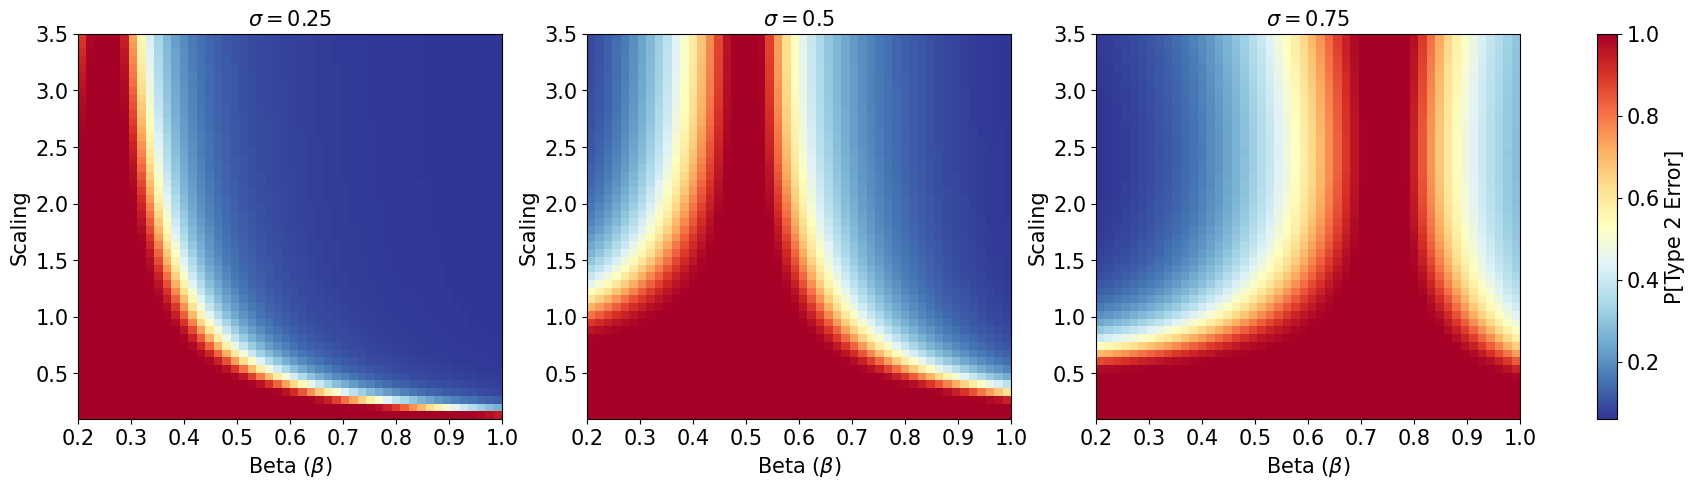

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
alpha = 0.05
n_paths = 128
T = 1.0
for i, sig in enumerate([0.25, 0.5, 0.75]):
    prob_errors = []
    for scaling in np.linspace(0.1, 3.5, 50):
        Z = []
        for beta in np.linspace(0.2, 1.0, 50):
            loc_h1 = Exp_Gamma_2_ub(scaling*sig, scaling*beta) + Exp_Gamma_3_ub(scaling*sig, scaling*beta)
            var_h1 = trunc_vol_H_A_dist(scaling*sig, scaling*beta, T)
            scale_h1 = np.sqrt(var_h1 * 4 * 1/n_paths)
            
            mean = Exp_MMD_2_b(scaling*sig, scaling*sig, n_paths)
            var  = Var_MMD_2_b(scaling*sig, scaling*sig, n_paths)
            mu    = scale(mean, var, n_paths)
            theta = rate(mean, var, n_paths)
            threshold_est = ppf(1-alpha, mu, theta, n_paths)
            
            
            Z.append(norm.cdf(threshold_est/n_paths, loc=loc_h1, scale=scale_h1))
        prob_errors.append(Z)
    im = ax[i].imshow(prob_errors, origin='lower', extent=(0.2, 1.0, 0.1, 3.5), cmap='RdYlBu_r', aspect='auto')
    ax[i].set_title(fr'$\sigma=${sig}', fontsize=15)
    ax[i].set_xlabel(r'Beta ($\beta$)', fontsize=15)
    ax[i].set_ylabel('Scaling', fontsize=15)
    plt.setp(ax[i].get_xticklabels(), fontsize=15)
    plt.setp(ax[i].get_yticklabels(), fontsize=15)
    
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.05, label='P[Type 2 Error]')
cbar.set_label('P[Type 2 Error]', fontsize=15)
cbar.ax.tick_params(labelsize=15)
filename = f'ScaledBMImages/scaledbm_typ2prob_heatmap_{n_paths}.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Under Null Hypothesis the Volatility Parameter is $\beta$

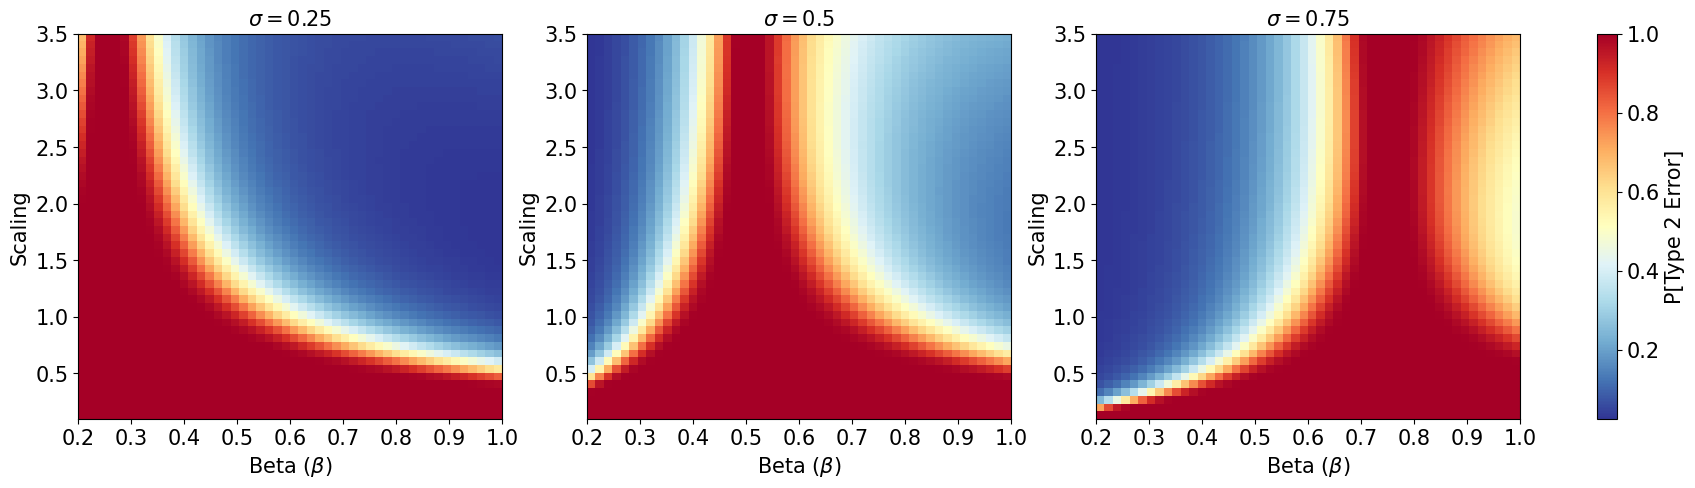

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
alpha = 0.05
n_paths = 128
T = 1.0
for i, sig in enumerate([0.25, 0.5, 0.75]):
    prob_errors = []
    for scaling in np.linspace(0.1, 3.5, 50):
        Z = []
        for beta in np.linspace(0.2, 1.0, 50):
            loc_h1 = Exp_Gamma_2_ub(scaling*sig, scaling*beta) + Exp_Gamma_3_ub(scaling*sig, scaling*beta)
            var_h1 = trunc_vol_H_A_dist(scaling*sig, scaling*beta, T)
            scale_h1 = np.sqrt(var_h1 * 4 * 1/n_paths)
            
            mean = Exp_MMD_2_b(scaling*beta, scaling*beta, n_paths)
            var  = Var_MMD_2_b(scaling*beta, scaling*beta, n_paths)
            mu    = scale(mean, var, n_paths)
            theta = rate(mean, var, n_paths)
            threshold_est = ppf(1-alpha, mu, theta, n_paths)
            
            
            Z.append(norm.cdf(threshold_est/n_paths, loc=loc_h1, scale=scale_h1))
        prob_errors.append(Z)
    im = ax[i].imshow(prob_errors, origin='lower', extent=(0.2, 1.0, 0.1, 3.5), cmap='RdYlBu_r', aspect='auto')
    ax[i].set_title(fr'$\sigma=${sig}', fontsize=15)
    ax[i].set_xlabel(r'Beta ($\beta$)', fontsize=15)
    ax[i].set_ylabel('Scaling', fontsize=15)
    plt.setp(ax[i].get_xticklabels(), fontsize=15)
    plt.setp(ax[i].get_yticklabels(), fontsize=15)
    
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.05, label='P[Type 2 Error]')
cbar.set_label('P[Type 2 Error]', fontsize=15)
cbar.ax.tick_params(labelsize=15)
filename = f'ScaledBMImages/scaledbm_typ2prob_heatmap_{n_paths}_rev.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

#### Probability of a Type 2 Error Occurring as a Function of the Batch Size

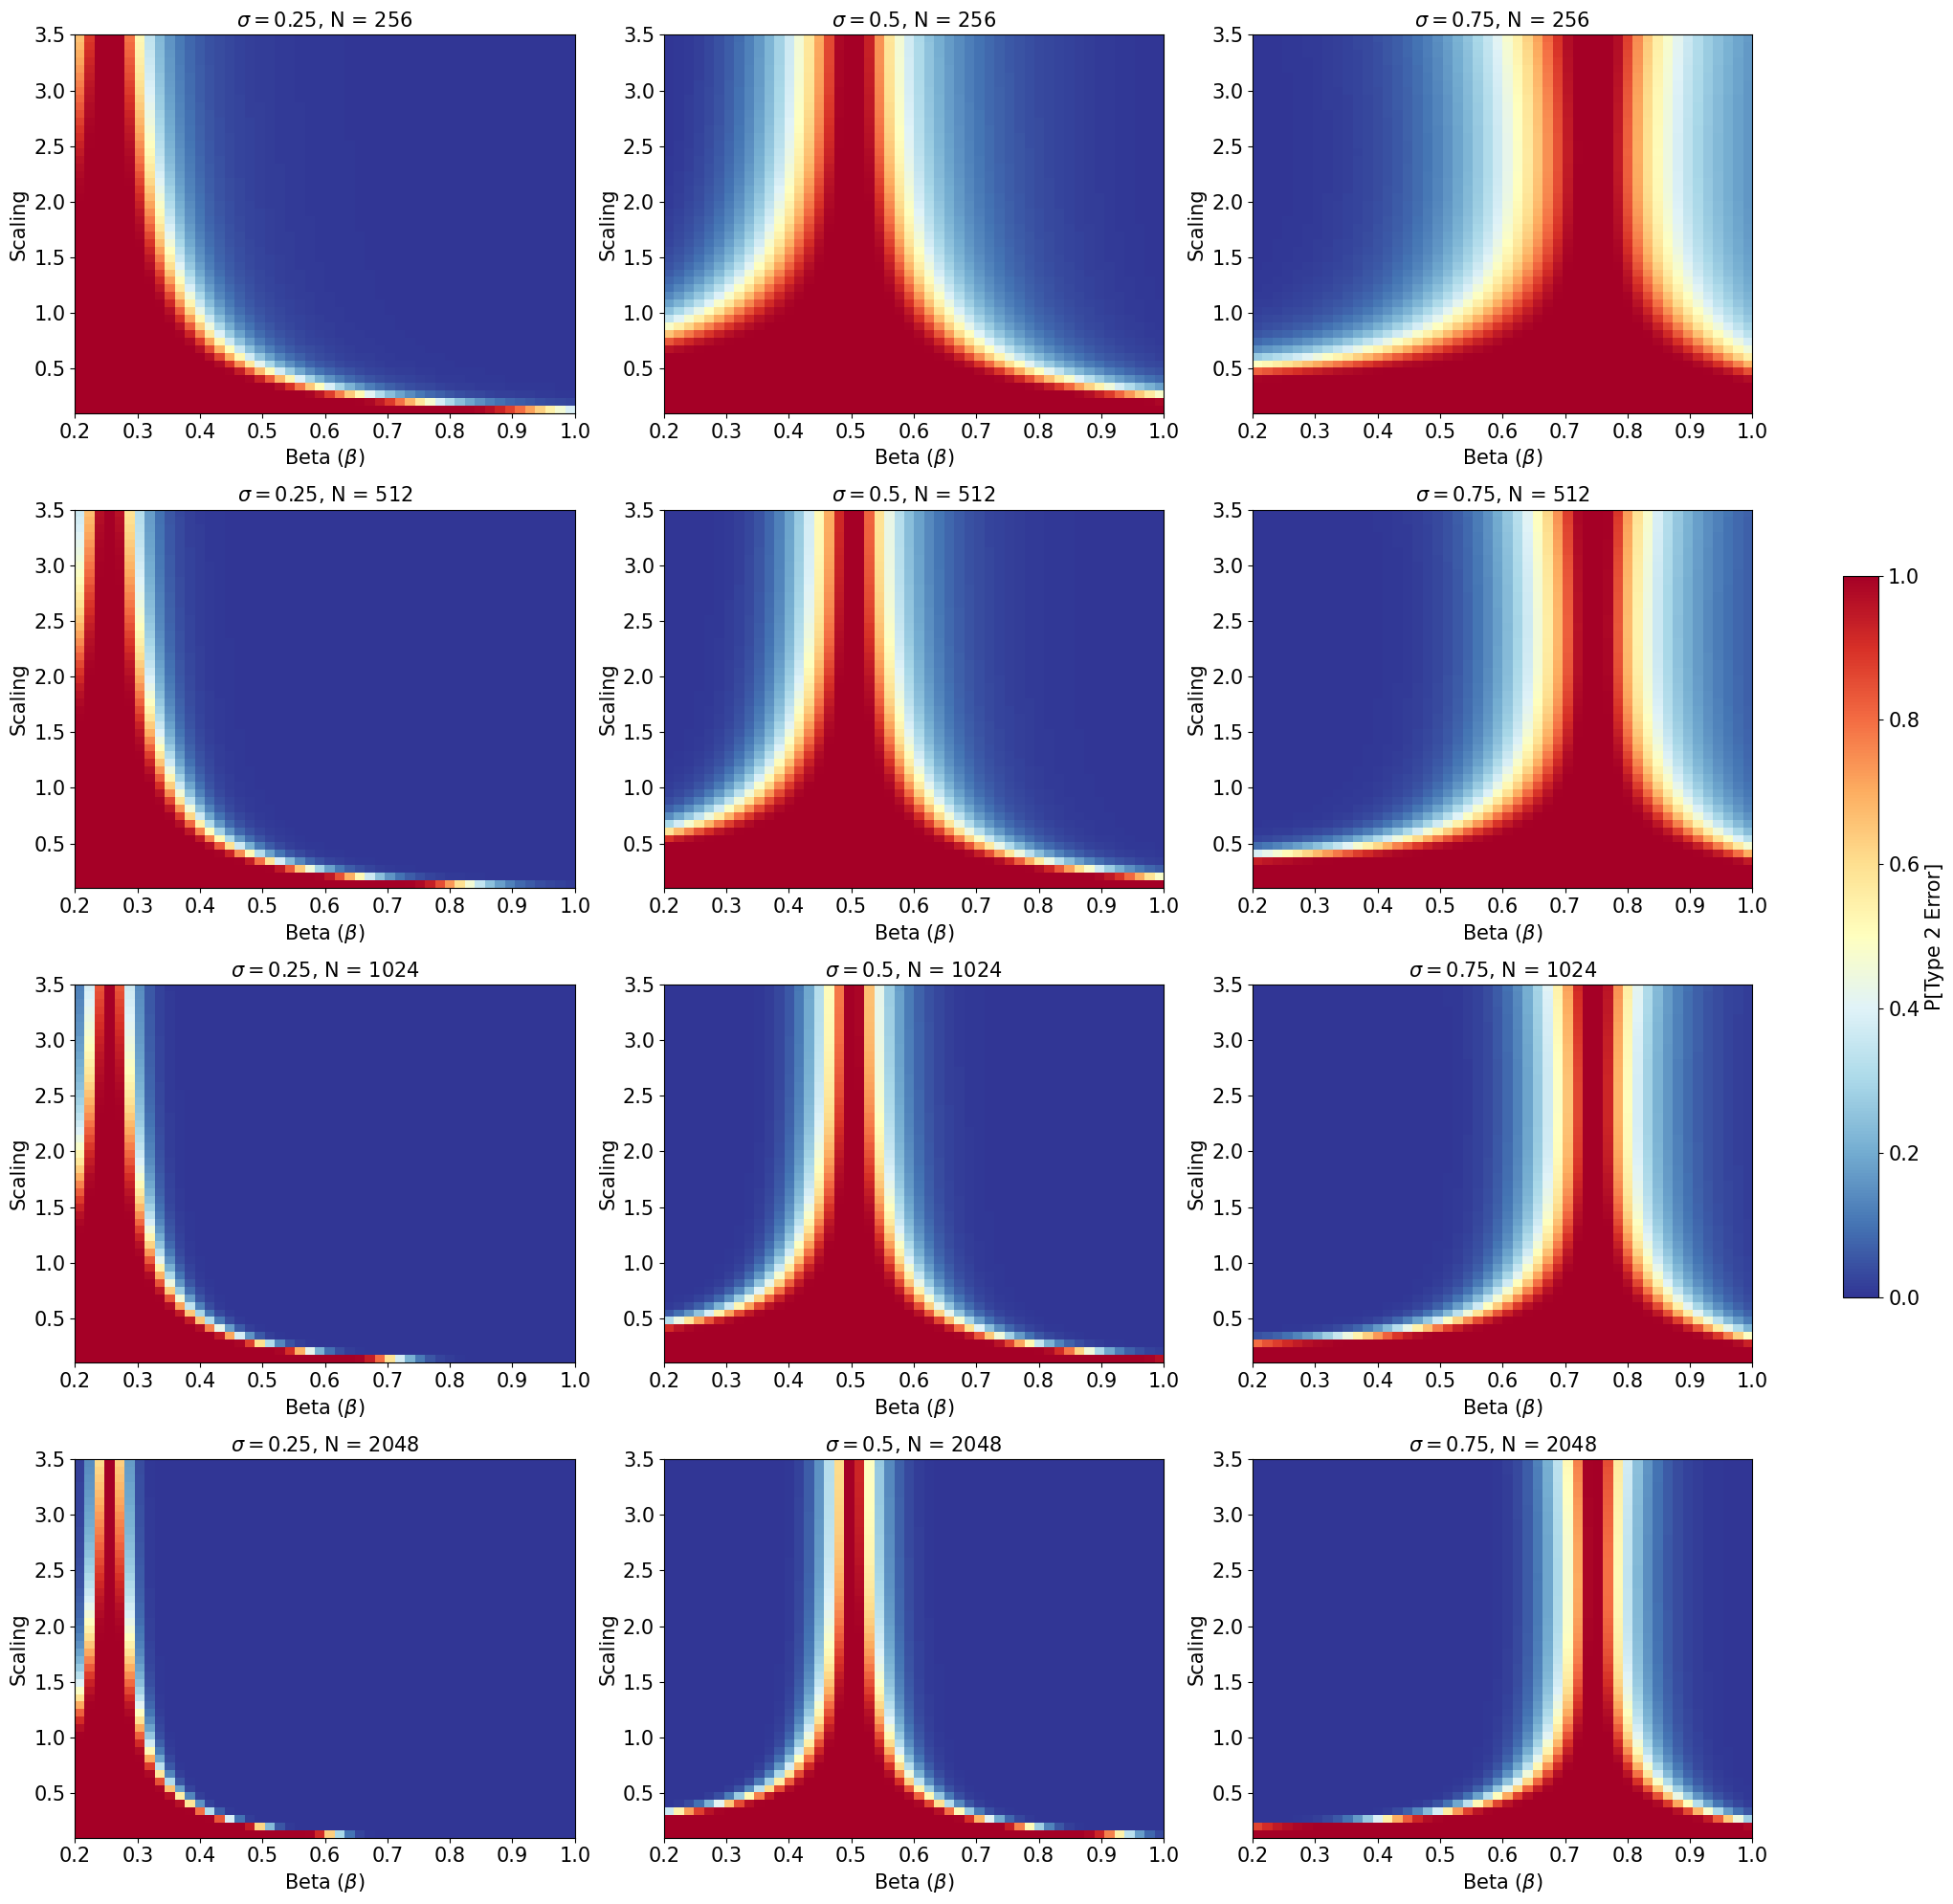

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
alpha = 0.05
T = 1.0
for i, n_paths in enumerate([256, 512, 1024, 2048]):
    for j, sig in enumerate([0.25, 0.5, 0.75]):
        prob_errors = []
        for scaling in np.linspace(0.1, 3.5, 50):
            Z = []
            for beta in np.linspace(0.2, 1.0, 50):
                loc_h1 = Exp_Gamma_2_ub(scaling*sig, scaling*beta) + Exp_Gamma_3_ub(scaling*sig, scaling*beta)
                var_h1 = trunc_vol_H_A_dist(scaling*sig, scaling*beta, T)
                scale_h1 = np.sqrt(var_h1 * 4 * 1/n_paths)

                mean = Exp_MMD_2_b(scaling*sig, scaling*sig, n_paths)
                var  = Var_MMD_2_b(scaling*sig, scaling*sig, n_paths)
                mu    = scale(mean, var, n_paths)
                theta = rate(mean, var, n_paths)
                threshold_est = ppf(1-alpha, mu, theta, n_paths)


                Z.append(norm.cdf(threshold_est/n_paths, loc=loc_h1, scale=scale_h1))
            prob_errors.append(Z)
        im = ax[i, j].imshow(prob_errors, origin='lower', extent=(0.2, 1.0, 0.1, 3.5), cmap='RdYlBu_r', aspect='auto')
        ax[i, j].set_title(fr'$\sigma=${sig}, N = {n_paths}', fontsize=15)
        ax[i, j].set_xlabel(r'Beta ($\beta$)', fontsize=15)
        ax[i, j].set_ylabel('Scaling', fontsize=15)
        plt.setp(ax[i, j].get_xticklabels(), fontsize=15)
        plt.setp(ax[i, j].get_yticklabels(), fontsize=15)
plt.tight_layout()  
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.05, label='P[Type 2 Error]')
cbar.set_label('P[Type 2 Error]', fontsize=15)
cbar.ax.tick_params(labelsize=15)
filename = f'ScaledBMImages/scaledbm_typ2prob_heatmap_path_list.svg'
file_path = Path(filename)
file_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()